In [13]:
%matplotlib notebook
%reset -f


import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


 Abrindo o documento e renomeando as colunas de alguns elementos das colunas

In [14]:
dados= pd.read_csv('suicide_.csv')
dados.rename(columns={'gdp_per_capita ($)':'gdp_capita'}, inplace=True)
dados.rename(columns={'HDI for year':'HDI'}, inplace=True)
dados.rename(columns={'suicides/100k pop' :'suicides_100k_pop'}, inplace=True)
dados.head()

,country,year,sex,age,suicides_no,population,suicides_100k_pop,country-year,HDI,gdp_for_year ($),gdp_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [15]:
def regress(X,Y):
    '''
    X: coluna(s) do DataFrame que serão utilizadas como variável(is) preditoras/explicativas (independente(s))
    Y: coluna do DataFrame que será utilizada como variável resposta (dependente)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results
df = dados[[ 'year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']].dropna()


In [16]:
df.describe()

,year,suicides_100k_pop,population,HDI,gdp_capita
count,8364.000000,8364.000000,8.364000e+03,8364.000000,8364.000000
mean,2005.348637,11.991936,1.852173e+06,0.776601,21074.371593
std,8.803020,17.361772,3.969754e+06,0.093367,22579.186968
min,1985.000000,0.000000,8.750000e+02,0.483000,313.000000
25%,2000.000000,1.040000,1.216425e+05,0.713000,4862.000000
50%,2010.000000,5.720000,4.722505e+05,0.779000,12584.000000
75%,2012.000000,15.442500,1.500290e+06,0.855000,30271.000000
max,2014.000000,187.060000,4.350934e+07,0.944000,126352.000000


Separando os sexos masculinos e femininos para a análise de dados

In [17]:
df.loc[df.sex == 'male', 'sex'] = 1
df.loc[df.sex == 'female', 'sex'] = 0
df.sex = df.sex.astype('int')
df.head()

,year,sex,age,suicides_100k_pop,population,HDI,gdp_capita,generation
72,1995,1,25-34 years,5.58,232900,0.619,835,Generation X
73,1995,1,55-74 years,5.06,178000,0.619,835,Silent
74,1995,0,75+ years,4.90,40800,0.619,835,G.I. Generation
75,1995,0,15-24 years,4.59,283500,0.619,835,Generation X
76,1995,1,15-24 years,4.56,241200,0.619,835,Generation X


Calculando a covariância entre anguns dados da tabela,  e calculando a média entre as faixas etárias 

0.7712278341274604
0.10294349190826733


<IPython.core.display.Javascript object>


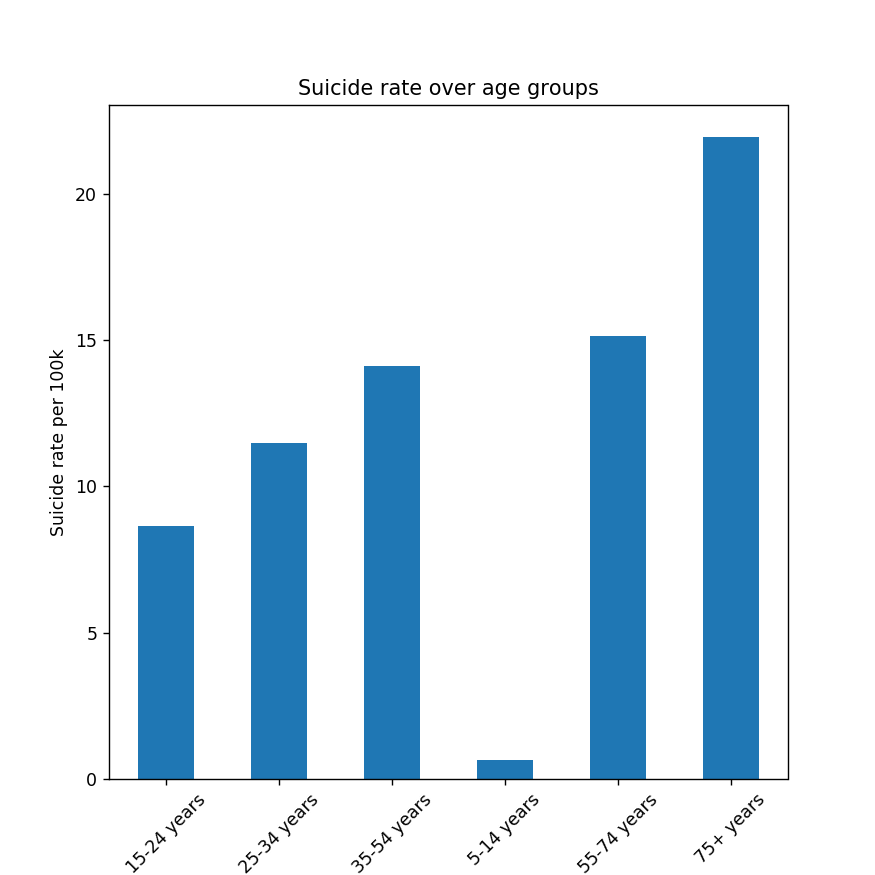

age
15-24 years     8.651736
25-34 years    11.467518
35-54 years    14.116133
5-14 years      0.628623
55-74 years    15.143006
75+ years      21.944598
Name: suicides_100k_pop, dtype: float64


sex
0     4.937198
1    19.046674
Name: suicides_100k_pop, dtype: float64

In [18]:
cor_hg= df.HDI.corr(df.gdp_capita)
print(cor_hg)
cor_ph= df.population.corr(df.HDI)
print(cor_ph)
media= df.suicides_100k_pop.groupby(by=df.age).mean()
plt.figure(figsize=(7,7))
media.plot.bar(rot=45)
plt.xlabel("Years",fontsize=10)
plt.ylabel("Suicide rate per 100k")
plt.title('Suicide rate over age groups')
plt.show()

print(media)
df.suicides_100k_pop.groupby(by=df.sex).mean()

Analisando os dados das  diferentes faixas etárias

In [19]:
f1=df.suicides_100k_pop[df.age=="5-14 years"].describe()
f2=df.suicides_100k_pop[df.age=="15-24 years"].describe()
f3=df.suicides_100k_pop[df.age=="25-34 years"].describe()
f4=df.suicides_100k_pop[df.age=="35-54 years"].describe()
f5=df.suicides_100k_pop[df.age=="55-74 years"].describe()
f6=df.suicides_100k_pop[df.age=="75+ years"].describe()

Plotando um histograma para analisar a média por país

<IPython.core.display.Javascript object>


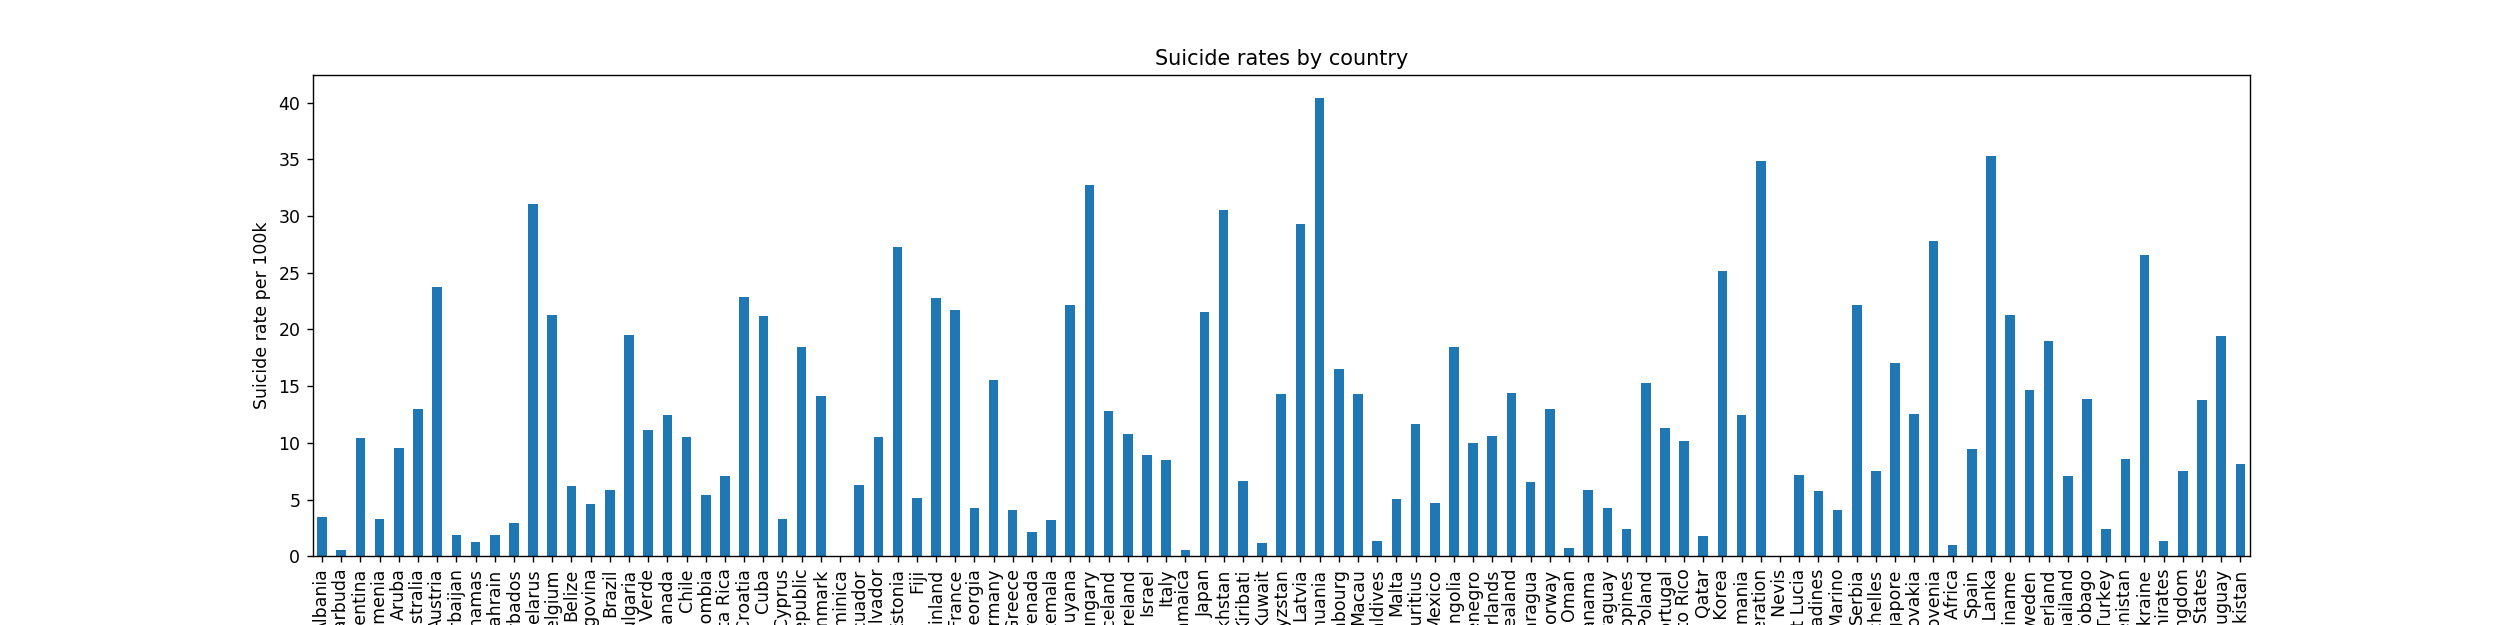

In [20]:
df_pais = dados[[ 'country','year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']]
mediaporpais=country_relevance= df_pais.suicides_100k_pop.groupby(by=df_pais.country).mean()
plt.figure(figsize=(20,5))
mediaporpais.plot.bar()
plt.xlabel('Country')
plt.ylabel("Suicide rate per 100k")
plt.title("Suicide rates by country")
plt.show()

Correlação entre os dados indicados na tabela

In [21]:
df2= df[['suicides_100k_pop', 'population','HDI',
'gdp_capita']]
df2.corr()

,suicides_100k_pop,population,HDI,gdp_capita
suicides_100k_pop,1.000000,-0.023197,0.074279,-0.002339
population,-0.023197,1.000000,0.102943,0.073701
HDI,0.074279,0.102943,1.000000,0.771228
gdp_capita,-0.002339,0.073701,0.771228,1.000000


<IPython.core.display.Javascript object>


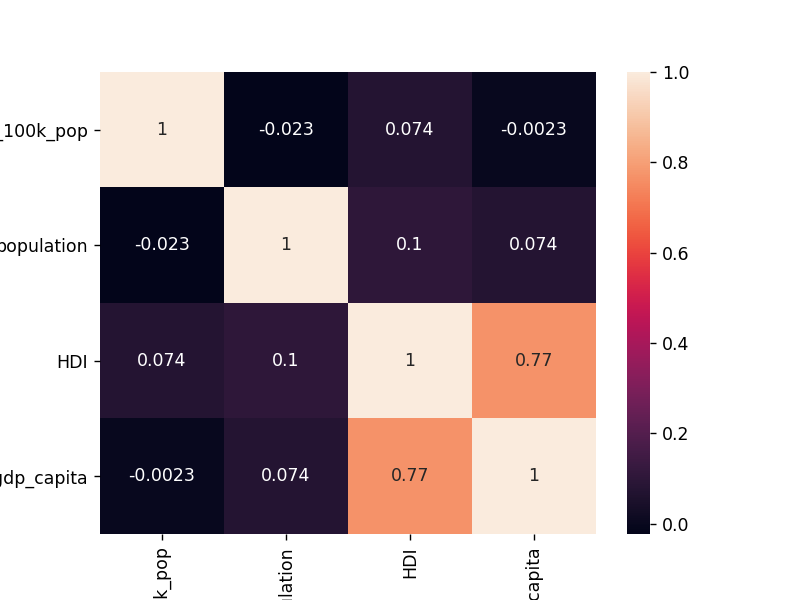

In [22]:
import seaborn

plt.figure()
seaborn.heatmap(df2.corr(), annot=True)
plt.show()

In [23]:
X = df[[ 'sex', 'year', 'population','HDI',
'gdp_capita']]
X = X.join(pd.get_dummies(df['age']))
X = X.join(pd.get_dummies(df['generation']))
Y = df['suicides_100k_pop']
results = regress(X,Y)
results.summary()

C:\Users\laura\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicides_100k_pop   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     281.2
Date:                Fri, 29 May 2020   Prob (F-statistic):               0.00
Time:                        22:26:13   Log-Likelihood:                -34030.
No. Observations:                8364   AIC:                         6.809e+04
Df Residuals:                    8348   BIC:                         6.820e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             340.6664     64.560      5.277      0.000     214.112     467.221
sex                14.1050      0.310     45.537      0.000      13.498      14.712
year               -0.2392      0.043     -5.553      0.000      -0.324      -0.155
population      -6.259e-08      4e-08     -1.566      0.117   -1.41e-07    1.58e-08
HDI                42.9483      2.685     15.995      0.000      37.685      48.212
gdp_capita         -0.0001   1.08e-05    -10.290      0.000      -0.000   -8.98e-05
15-24 years        53.2400     10.234      5.202      0.000      33.179      73.301
25-34 years        56.2373     10.423      5.395      0.000      35.805      76.670
35-54 years        59.4993     10.885      5.466      0.000      38.161      80.837
5-14 years         43.7512      9.859      4.438      0.000      24.426      63.077
55-74 years        60.6899     11.456      5.298      0.000      38.234      83.146
75+ years          67.2486     11.785      5.706      0.000      44.148      90.349
Boomers            55.8543     10.494      5.322      0.000      35.283      76.426
G.I. Generation    58.2005      9.412      6.183      0.000      39.750      76.651
Generation X       56.1156     11.024      5.091      0.000      34.507      77.725
Generation Z       59.1213     12.073      4.897      0.000      35.455      82.788
Millenials         56.7730     11.578      4.904      0.000      34.077      79.469
Silent             54.6017     10.079      5.417      0.000      34.844      74.360
==============================================================================
Omnibus:                     4881.797   Durbin-Watson:                   0.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66121.901
Skew:                           2.549   Prob(JB):                         0.00
Kurtosis:                      15.796   Cond. No.                     3.67e+22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
X.dtypes


sex                  int32
year                 int64
population           int64
HDI                float64
gdp_capita           int64
15-24 years          uint8
25-34 years          uint8
35-54 years          uint8
5-14 years           uint8
55-74 years          uint8
75+ years            uint8
Boomers              uint8
G.I. Generation      uint8
Generation X         uint8
Generation Z         uint8
Millenials           uint8
Silent               uint8
dtype: object